# Make plots showing spatial variability of various depth- and time-integrated mixing quantities 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import pandas as pd
# %matplotlib inline

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')
crs = ccrs.PlateCarree(central_longitude=-93.5)

In [2]:
# Open the parent and child models 
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

path1 = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/nest/ver1/ocean_avg_child_0000*.nc')
ds_avg_child = xroms.open_mfnetcdf(path1)
ds_avg_child, grid_avg_child = xroms.roms_dataset(ds_avg_child)

#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

#Child model slices
xislice_child = slice(8, 677-8)
etaslice_child = slice(8, 602-8)

In [3]:
def calc_kh(ds):
    '''
Calculates the horizontal eddy diffusivity scaled to 
the grid size
    '''
    dA = ds.dA
    dA_max = (np.sqrt(dA)).max()
    kh_0 = 1.0 #m^2/s
    kh = (kh_0/dA_max)*(np.sqrt(dA))
    return kh

kh_parent = calc_kh(ds_avg)
kh_child = calc_kh(ds_avg_child)

print('Mean k_h Parent [m^2/s]: ', kh_parent.mean().values)
print('Mean k_h Child [m^2/s]: ', kh_child.mean().values)

Mean k_h Parent [m^2/s]:  0.43943411977069297
Mean k_h Child [m^2/s]:  0.8804877431110936


# Open outputs

In [4]:
#Depth integrated resolved physical mixing
chi_dz = xr.open_mfdataset('/d2/home/dylan/JAMES/histogram_outputs/depth_int_mixing/chi_dz_2010_srho_*.nc').chi_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chi_dz_child = xr.open_mfdataset('/d2/home/dylan/JAMES/histogram_outputs/depth_int_mixing/chi_dz_child_2010_*.nc').chi_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

#Depth integrated resolved horizontal mixing
chih_dz = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/chi_horz_depth_integ/chih_dz_2010_srho_*.nc').chih_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chih_dz_child = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/t1/chih_dz_2010_srho_*.nc').chih_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

#Depth integrated numerical mixing mixing
mnum_dz = xr.open_mfdataset('/d2/home/dylan/JAMES/histogram_outputs/depth_int_mixing/mnum_dz_2010_srho_*.nc').mnum_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_dz_child = xr.open_mfdataset('/d2/home/dylan/JAMES/histogram_outputs/depth_int_mixing/mnum_dz_child_2010_*.nc').mnum_dz.sel(ocean_time = slice('2010-06-03', '2010-07-13'))

dt = 3600
chi_tint = (chi_dz.cumsum('ocean_time')*dt)#.load()
chi_tint_child = (chi_dz_child.cumsum('ocean_time')*dt)#.load()

chih_tint = (chih_dz.cumsum('ocean_time')*dt)#.load()
chih_tint_child = (chih_dz_child.cumsum('ocean_time')*dt)#.load()

mnum_tint = (mnum_dz.cumsum('ocean_time')*dt)#.load()
mnum_tint_child = (mnum_dz_child.cumsum('ocean_time')*dt)#.load()

# Make plots 

/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/d2/home/dylan/.conda/envs/copano/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically i

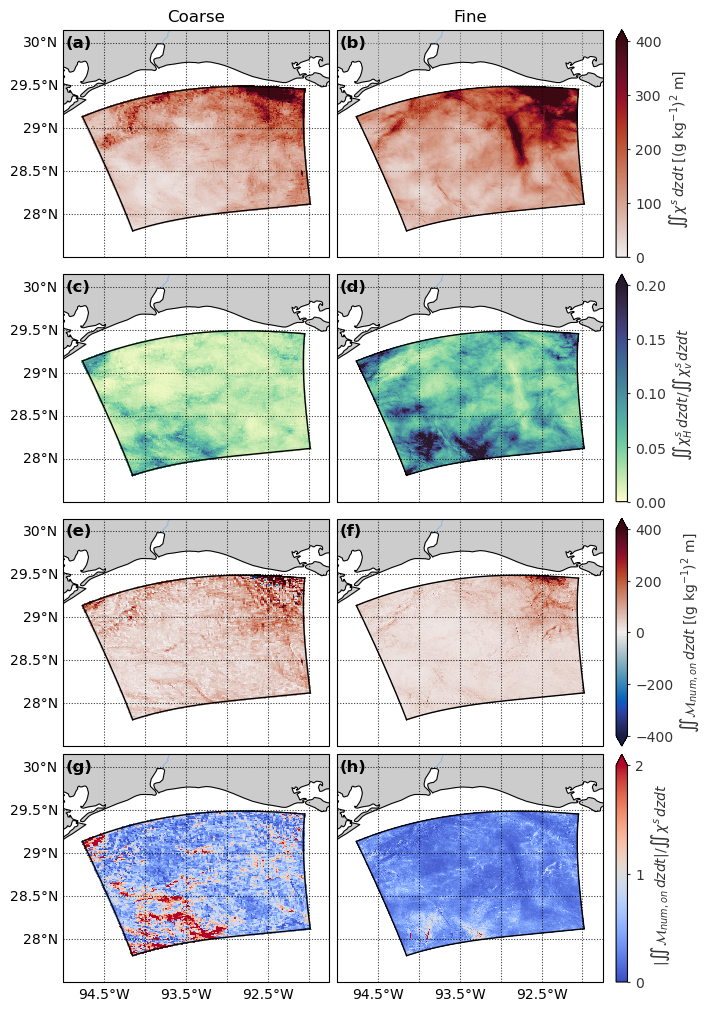

In [5]:
import matplotlib.ticker as tick
plt.rcParams.update({'font.size': 10})
fig,ax = plt.subplots(4,2, figsize = (7,10), subplot_kw={'projection': crs}, constrained_layout = True)

#Total resolved physical mixing 
mappable = ax[0,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                            ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                            chi_tint.isel(ocean_time=-1)+chih_tint.isel(ocean_time=-1), vmin = 0, vmax = 400,
                            cmap = cmo.amp,
                            transform = ccrs.PlateCarree())

mappable1 = ax[0,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                            ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                            chi_tint_child.isel(ocean_time=-1)+chih_tint_child.isel(ocean_time=-1), 
                            cmap = cmo.amp,vmin = 0, vmax = 400,
                            transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[0,1], extend = 'max')
cb.set_label(r'$\iint \chi^s \, dzdt$ [(g kg$^{-1}$)$^2$ m]', color='0.2')
cb.ax.tick_params(length=2, color='0.2', labelcolor='0.2')

#Ratio of horz. to vertical physical mixing
mappable = ax[1,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                              ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             ((chih_tint.isel(ocean_time=-1))/chi_tint.isel(ocean_time=-1)), vmin = 0, vmax = 0.20,
                              cmap = cmo.deep,
                              transform = ccrs.PlateCarree())

mappable = ax[1,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                              ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             ((chih_tint_child.isel(ocean_time=-1))/chi_tint_child.isel(ocean_time=-1)), vmin = 0, vmax = 0.20,
                              cmap = cmo.deep,
                              transform = ccrs.PlateCarree(), )

cb = fig.colorbar(mappable, ax = ax[1,1], extend = 'max', ticks = [0, 0.05, 0.1, 0.15, 0.2]) #, format=tick.FormatStrFormatter('$10^{%d}$')
cb.set_label(r'$\iint \chi_H^s \, dzdt/ \iint \chi_v^s \, dzdt$', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

#Online numerical mixing
mappable = ax[2,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             mnum_tint.isel(ocean_time=-1), vmin = -400, vmax = 400,
                             cmap = cmo.balance,
                             transform = ccrs.PlateCarree())

mappable1 = ax[2,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             mnum_tint_child.isel(ocean_time=-1), 
                             cmap = cmo.balance, vmin = -400, vmax = 400,
                             transform = ccrs.PlateCarree())


cb = fig.colorbar(mappable, ax = ax[2,1], extend = 'both', ticks = [-400, -200, 0, 200, 400],)
cb.set_label(r'$\iint \mathcal{M}_{num, on} \, dzdt$ [(g kg$^{-1}$)$^2$ m]', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

#Ratio of numerical to physical mixing
mappable = ax[3,0].pcolormesh(ds_avg.lon_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                              ds_avg.lat_rho.isel(eta_rho = etaslice, xi_rho = xislice),
                             (np.abs(mnum_tint.isel(ocean_time=-1))/chi_tint.isel(ocean_time=-1)), vmin = 0, vmax = 2,
                              cmap = plt.get_cmap('coolwarm'),
                              transform = ccrs.PlateCarree())

mappable = ax[3,1].pcolormesh(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                              ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child),
                             (np.abs(mnum_tint_child.isel(ocean_time=-1))/chi_tint_child.isel(ocean_time=-1)), vmin = 0, vmax = 2,
                              cmap = plt.get_cmap('coolwarm'),
                              transform = ccrs.PlateCarree())

cb = fig.colorbar(mappable, ax = ax[3,1], extend = 'max', ticks = [0, 1, 2],)
cb.set_label(r'$|\iint \mathcal{M}_{num, on} \, dzdt|/\iint \chi^s \, dzdt$', color='0.2')
cb.ax.tick_params(length=2, color='0.2',  labelcolor='0.2')

#Plot boundaries of control volume
for i in range(4):
    for j in range(2):
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child)[-1,:], 
                     ds_avg_child.lat_rho.isel(eta_rho = etaslice_child, xi_rho = xislice_child)[-1,:], 'k', 
                                    lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[0,:], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[0,:], 
                                    'k', lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[:,0], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[:,0], 
                                    'k', lw=1,transform = ccrs.PlateCarree())
        ax[i,j].plot(ds_avg_child.lon_rho.isel(eta_rho = etaslice_child,
                                    xi_rho = xislice_child)[:,-1], 
                                    ds_avg_child.lat_rho.isel(eta_rho = etaslice_child,
                                                        xi_rho = xislice_child)[:,-1], 'k', 
                                    lw=1,transform = ccrs.PlateCarree())

        ax[i,j].set_aspect('auto')
        ax[i,j].set_extent([-95, -91.75, 27.5, 30.15], ccrs.PlateCarree())
        ax[i,j].add_feature(land_10m, facecolor='0.8')
        ax[i,j].coastlines(resolution='10m', linewidth = 0.75)  
        ax[i,j].add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.75)
        ax[i,j].add_feature(cfeature.RIVERS, linewidth=0.75)
        ax[i,j].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)

#Grid lines
gl = ax[0,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[1,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[1,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False 
gl.left_labels = False

gl = ax[2,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = False
gl.left_labels = True

gl = ax[2,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=False)

gl = ax[3,0].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True 
gl.left_labels = True

gl = ax[3,1].gridlines(linewidth=0.75, color='black', alpha=0.5, linestyle='dotted', draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = False

#Labelling
ax[0,0].set_title('Coarse')
ax[0,1].set_title('Fine')

ax[0,0].annotate('(a)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[0,1].annotate('(b)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[0,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,0].annotate('(c)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[1,1].annotate('(d)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[1,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,0].annotate('(e)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[2,1].annotate('(f)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[2,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,0].annotate('(g)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,0]),
                 color = 'k', fontsize = 12,  fontweight='bold')
ax[3,1].annotate('(h)', xy = (-94.97, 29.95), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax[3,1]),
                 color = 'k', fontsize = 12,  fontweight='bold')
fig.canvas.draw()

# plt.savefig('dzdt_int_mixing.jpg', dpi = 300, bbox_inches="tight")  